<a href="https://colab.research.google.com/github/shadigoodarzi/HelloWorld/blob/master/Resnet_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Trafic_Safety/'

Mounted at /content/gdrive


In [2]:
from pathlib import Path
path = Path(base_dir)
path

PosixPath('/content/gdrive/My Drive/Trafic_Safety')

# Set up the libraries & random seed

In [3]:
#Set all the random seeds
# Set a seed value
seed_value= 12321 
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
%tensorflow_version 1.15 #Use tensorflow 1. something instead of 2
import tensorflow as tf
tf.set_random_seed(seed_value)
# 5. For layers that introduce randomness like dropout, make sure to 
#set seed values 
#6 Configure a new global `tensorflow` session
import keras
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
keras.backend.set_session(sess)   

#plotting & data manipulation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import image
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy import stats
import time
#import cv2
from PIL import Image
#Deep Learning modules
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization
from keras import layers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint
#Import pretrained models
from keras.applications.resnet50 import ResNet50, preprocess_input,decode_predictions
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg19 import VGG19
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.xception import Xception
#from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.mobilenet import MobileNet
#from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
#from keras.applications.nasnet import NASNetLarge, NASNetMobile
#from keras.preprocessing.image import ImageDataGenerator



def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15 #Use tensorflow 1. something instead of 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


# Read Data

In [4]:
intersections = pd.read_sas(path/'Data/traffic_intersection_stack.sas7bdat')
cols=list(intersections.columns)
data = intersections[['type', 'lat', 'long', 'angle', 'id']]
data[['type','id']].groupby(['type']).agg(['count'])
#data = data.sample(frac=1) #randomly shuffle dataframe
folderpath = path/"Data/TerrainOtsuImages/"
#Set Current directory
os.chdir(folderpath)
os.getcwd()


'/content/gdrive/My Drive/Trafic_Safety/Data/TerrainOtsuImages'

In [5]:
#Checking GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
os.chdir(folderpath)
imageArray = []
imageLabel = []
HEIGHT = 300
WIDTH = 300
ids = data['id']
i = 0 
for inter_id in ids:
    #Read image
    img = Image.open( "Terrain_Otsu_" + str(int(inter_id)) + ".png")
    #Display image
#    img.show()
    #Resize all images HEIGHT*WIDTH
    img = img.resize((HEIGHT, WIDTH))
        #img = Image.open(topFolderPath + folderName + '/' + image)  # convert image to 8-bit grayscale
        #img = img.resize((HEIGHT, WIDTH))
    img = np.asarray(img, dtype="float32")
    #Creating a three channel image
    img2=np.zeros([HEIGHT, WIDTH, 3])
    img2[:,:,0]=img
    img2[:,:,1]=img
    img2[:,:,2]=img
    imageArray.append([img2])
    #print(plt.imshow(img2))
    imageLabel.append(int(data["type"].iloc[i]))
    print("Image number " + str(i+1) + " out of 3414 just finished!")
    i = i+1
del intersections

Image number 1 out of 3414 just finished!
Image number 2 out of 3414 just finished!
Image number 3 out of 3414 just finished!
Image number 4 out of 3414 just finished!
Image number 5 out of 3414 just finished!
Image number 6 out of 3414 just finished!
Image number 7 out of 3414 just finished!
Image number 8 out of 3414 just finished!
Image number 9 out of 3414 just finished!
Image number 10 out of 3414 just finished!
Image number 11 out of 3414 just finished!
Image number 12 out of 3414 just finished!
Image number 13 out of 3414 just finished!
Image number 14 out of 3414 just finished!
Image number 15 out of 3414 just finished!
Image number 16 out of 3414 just finished!
Image number 17 out of 3414 just finished!
Image number 18 out of 3414 just finished!
Image number 19 out of 3414 just finished!
Image number 20 out of 3414 just finished!
Image number 21 out of 3414 just finished!
Image number 22 out of 3414 just finished!
Image number 23 out of 3414 just finished!
Image number 24 out 

# Create train and validation sets

In [0]:
train = np.array(np.asarray([i[0] for i in imageArray])).reshape(-1, HEIGHT, WIDTH, 3) 
train_labels = np.array(imageLabel)
train_labels_dums = pd.get_dummies(train_labels)
train_labels_dums = np.array(train_labels_dums)
index=range(len(train_labels_dums))
x_train, x_val, y_train, y_val, idx_train, idx_val = train_test_split(train, 
                                                                      train_labels_dums,
                                                                      index,
                                                                      test_size=0.2, 
                                                                      random_state=seed_value)
data[['type','id']].groupby(['type']).agg(['count'])
del train

# Load Pretrained Model

In [8]:
#Resize all images HEIGHT*WIDTH
HEIGHT = 300
WIDTH = 300
base_model = ResNet50(weights='imagenet', 
                      include_top=False, #Drop the fully connected layer
                      input_shape=(HEIGHT, WIDTH, 3))

base_model.summary()
#Create a data generator to augment training data
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )
#Create & Save the augmented images in aug_images folder
if not os.path.exists('aug_images'):
    os.makedirs('aug_images')
train_generator=train_datagen.flow(x_train, y_train,
                                   batch_size=BATCH_SIZE,seed=seed_value,
                                   save_to_dir='aug_images', save_prefix='aug', save_format='png')

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
#Build a model with pretrained weights and fully connected layer+soft max
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False #Keep original weight of pretrained model

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(rate=dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = [0,1]
FC_LAYERS = [1024, 1024]
dropout = 0.025

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))


NUM_EPOCHS = 20#10
BATCH_SIZE = 8
LR=0.0001
num_train_images = len(y_train)
#Choose small learning rate because we are only fine tuning 
adam = Adam(lr=LR)#,decay=1e-2/NUM_EPOCHS)#
finetune_model.compile(optimizer=adam, loss='categorical_crossentropy', 
                       metrics=['accuracy','categorical_accuracy'])
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
filepath="./checkpoints/" + "ResNet50" + "_epoch_"+str(NUM_EPOCHS)+"_batch_"+str(BATCH_SIZE)+"_model_weights.h5"
#Keep track of each epoch using checkpoints
checkpoint = ModelCheckpoint(filepath, monitor=["acc",'categorical_accuracy'],
                             verbose=1, mode='max')
callbacks_list = [checkpoint]

# Run the Model

In [15]:
start=time.time()
history2 = finetune_model.fit(x_train,y_train, epochs=NUM_EPOCHS, 
                                       workers=8, 
                                       validation_data=(x_val, y_val),
                                       shuffle=True)#, callbacks=callbacks_list)

end=time.time()
print('Process Time:')
timer(start,end)

Train on 2731 samples, validate on 683 samples
Epoch 1/20
2731/2731 [==============================] - 28s 10ms/step - loss: 3.0305 - acc: 0.7272 - categorical_accuracy: 0.7272 - val_loss: 0.7632 - val_acc: 0.8331 - val_categorical_accuracy: 0.8331
Epoch 2/20
2731/2731 [==============================] - 23s 8ms/step - loss: 0.5032 - acc: 0.8836 - categorical_accuracy: 0.8836 - val_loss: 0.7314 - val_acc: 0.7716 - val_categorical_accuracy: 0.7716
Epoch 3/20
2731/2731 [==============================] - 23s 8ms/step - loss: 0.1008 - acc: 0.9700 - categorical_accuracy: 0.9700 - val_loss: 0.7813 - val_acc: 0.7716 - val_categorical_accuracy: 0.7716
Epoch 4/20
2731/2731 [==============================] - 23s 8ms/step - loss: 0.0221 - acc: 0.9916 - categorical_accuracy: 0.9916 - val_loss: 0.6256 - val_acc: 0.8170 - val_categorical_accuracy: 0.8170
Epoch 5/20
2731/2731 [==============================] - 23s 8ms/step - loss: 0.0125 - acc: 0.9952 - categorical_accuracy: 0.9952 - val_loss: 0.7003 

# Evaluate the Model

In [11]:
history2.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_categorical_accuracy', 'loss', 'acc', 'categorical_accuracy'])

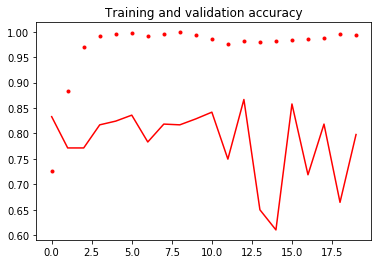

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')
plot_training(history2)


In [18]:
train_score = finetune_model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    
test_score = finetune_model.evaluate(x_val, y_val, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train loss: 1.5446058615622003, Train accuracy: 0.7978762358983591
Test loss: 1.6211344117126911, Test accuracy: 0.7979502195320576


In [19]:
start=time.time()
history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
                                       workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       validation_data=(x_val, y_val),
                                       shuffle=True)#, callbacks=callbacks_list)

end=time.time()
print('Process Time:')
timer(start,end)

Epoch 1/20
341/341 [==============================] - 159s 465ms/step - loss: 6.2849 - acc: 0.6068 - categorical_accuracy: 0.6068 - val_loss: 6.6785 - val_acc: 0.5857 - val_categorical_accuracy: 0.5857
Epoch 2/20
341/341 [==============================] - 161s 471ms/step - loss: 6.4677 - acc: 0.5987 - categorical_accuracy: 0.5987 - val_loss: 6.6785 - val_acc: 0.5857 - val_categorical_accuracy: 0.5857
Epoch 3/20
341/341 [==============================] - 161s 473ms/step - loss: 6.4066 - acc: 0.6025 - categorical_accuracy: 0.6025 - val_loss: 6.6785 - val_acc: 0.5857 - val_categorical_accuracy: 0.5857
Epoch 4/20
341/341 [==============================] - 161s 473ms/step - loss: 6.4795 - acc: 0.5980 - categorical_accuracy: 0.5980 - val_loss: 6.6785 - val_acc: 0.5857 - val_categorical_accuracy: 0.5857
Epoch 5/20
341/341 [==============================] - 161s 471ms/step - loss: 6.4559 - acc: 0.5995 - categorical_accuracy: 0.5995 - val_loss: 6.6785 - val_acc: 0.5857 - val_categorical_accurac

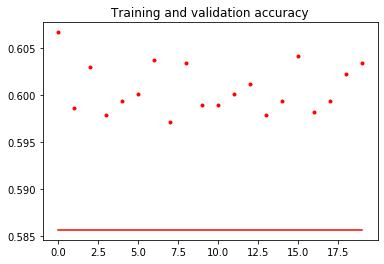

<Figure size 432x288 with 0 Axes>

In [20]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')
plot_training(history)

In [21]:
train_score = finetune_model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
    
test_score = finetune_model.evaluate(x_val, y_val, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train loss: 6.44487743000546, Train accuracy: 0.6001464665503521
Test loss: 6.678508082036567, Test accuracy: 0.5856515375970921
